In [1]:
# import all libraries and modules needed
import os
import sys
import datetime
import glob
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

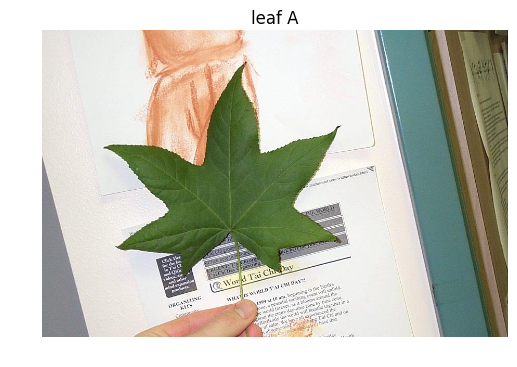

In [5]:
img = load_img('data/train/leaf_01/image_0021.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('leaf A')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

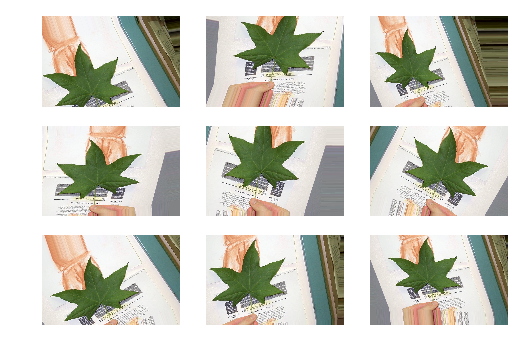

In [7]:
i = 0
fig = plt.figure()
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

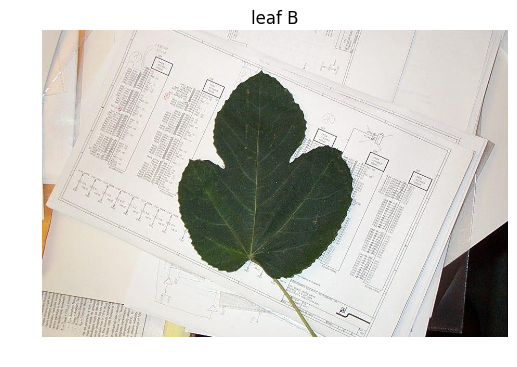

In [8]:
img = load_img('data/train/leaf_02/image_0086.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('leaf B')
plt.show()

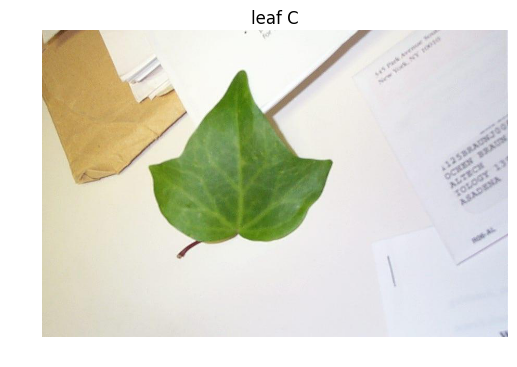

In [9]:
img = load_img('data/train/leaf_03/image_0157.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('leaf C')
plt.show()

In [10]:
# default settings
img_width, img_height = 224, 224

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [11]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

136


In [12]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

37


In [13]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# data pre-processing for validating
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [15]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 136 images belonging to 3 classes.


In [16]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 37 images belonging to 3 classes.


In [17]:
# set up transfer learning on pre-trained ImageNet VGG19 model - remove fully connected layer and replace
# with softmax for classifying 2 classes
vgg19_model = VGG19(weights = 'imagenet', include_top = False, input_shape =(img_width, img_height, 3))
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg19_model.input, output = predictions)

In [18]:
# freeze all layers of the pre-trained model
for layer in vgg19_model.layers:
    layer.trainable = False

In [19]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [20]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
136/136 [==============================] - 103s - loss: 1.8867 - acc: 0.3529 - val_loss: 1.0783 - val_acc: 0.3514
Epoch 2/20
136/136 [==============================] - 101s - loss: 0.9458 - acc: 0.5221 - val_loss: 0.9284 - val_acc: 0.5405
Epoch 3/20
136/136 [==============================] - 101s - loss: 0.8392 - acc: 0.5515 - val_loss: 0.7888 - val_acc: 0.6216
Epoch 4/20
136/136 [==============================] - 101s - loss: 0.7302 - acc: 0.7059 - val_loss: 0.6805 - val_acc: 0.7568
Epoch 5/20
136/136 [==============================] - 101s - loss: 0.5895 - acc: 0.7647 - val_loss: 0.7520 - val_acc: 0.5946
Epoch 6/20
136/136 [==============================] - 101s - loss: 0.6291 - acc: 0.7132 - val_loss: 0.8893 - val_acc: 0.6216
Epoch 7/20
136/136 [==============================] - 101s - loss: 0.6233 - acc: 0.8235 - val_loss: 0.5947 - val_acc: 0.7568
Epoch 8/20
136/136 [==============================] - 101s - loss: 0.4939 - acc: 0.8235 - val_loss: 0.4061 - val_acc: 0.9459


In [21]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.132914230227
Test Accuracy: 0.96875


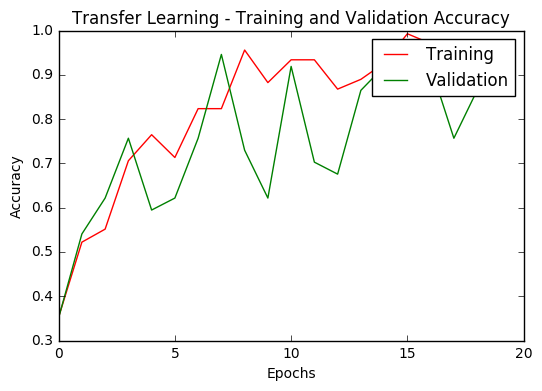

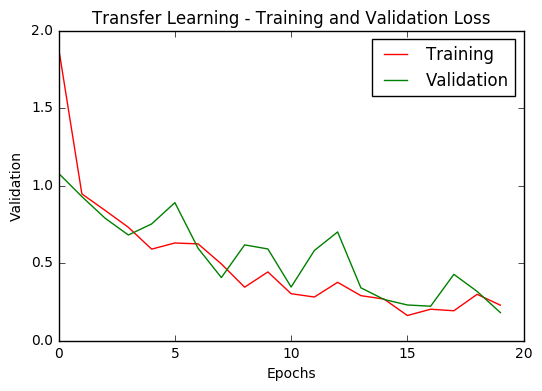

In [22]:
# plot the accuracy and loss data
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

plt.figure()
plt.plot(epochs, xfer_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, xfer_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation")
plt.legend()
plt.show()

In [23]:
model.save('leaves_vgg19_model_tl.h5')

In [24]:
# display the layers in the pretrained model
for i, layer in enumerate(vgg19_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool


In [25]:
# display the details of the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [26]:
# Step 1 - Set up fine tuning on pre-trained ImageNet VGG19 model - freeze lower 94 layers only
for layer in model.layers:
    layer.trainable = True

# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
136/136 [==============================] - 248s - loss: 0.0739 - acc: 0.9877 - val_loss: 0.0614 - val_acc: 0.9910
Epoch 2/20
136/136 [==============================] - 246s - loss: 0.0638 - acc: 0.9951 - val_loss: 0.0786 - val_acc: 0.9730
Epoch 3/20
136/136 [==============================] - 247s - loss: 0.0444 - acc: 0.9951 - val_loss: 0.1182 - val_acc: 0.9640
Epoch 4/20
136/136 [==============================] - 247s - loss: 0.0369 - acc: 0.9951 - val_loss: 0.0522 - val_acc: 1.0000
Epoch 5/20
136/136 [==============================] - 247s - loss: 0.0355 - acc: 0.9951 - val_loss: 0.0460 - val_acc: 0.9910
Epoch 6/20
136/136 [==============================] - 248s - loss: 0.0232 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9820
Epoch 7/20
136/136 [==============================] - 248s - loss: 0.0200 - acc: 0.9951 - val_loss: 0.0412 - val_acc: 0.9820
Epoch 8/20
136/136 [==============================] - 248s - loss: 0.0182 - acc: 0.9951 - val_loss: 0.0305 - val_acc: 1.0000


In [27]:
# evaluate the performance the revised model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.00583112286404
Test Accuracy: 1.0


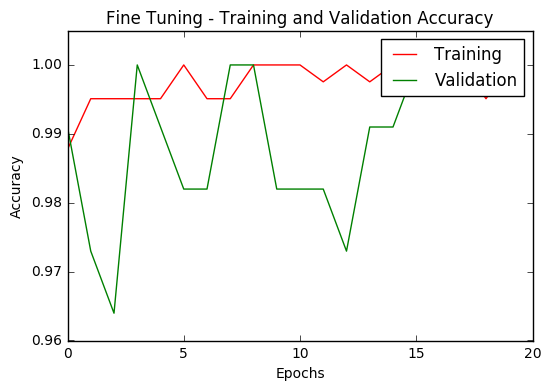

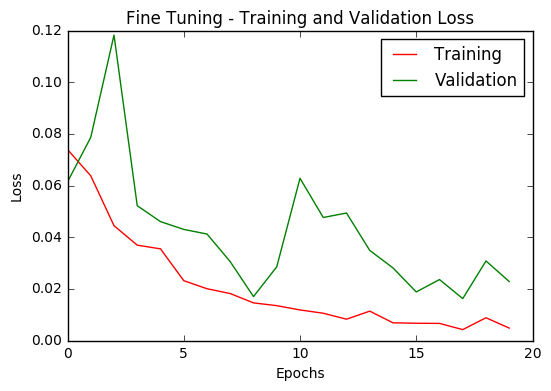

In [28]:
# plot the accuracy and loss data
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

plt.plot(epochs, ft_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, ft_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [29]:
model.save('leaves_vgg19_model_ft.h5')